# Stellargraph example: Simplified Graph Convolutions (SGC) on the CORA citation dataset

This notebook demonstrates the use of `StellarGraph`'s GCN, (2), class for training the simplified graph convolution (SGC) model in introduced in (1).

We show how to use `StellarGraph` to perform node attribute inference on the Cora citation network using SGC by creating a single layer GCN model with softmax activation.

SGC simplifies GCN in the following ways,

 - It removes the non-linearities in the graph convolutional layers.
 - It smooths the node input features using powers of the normalized adjacency matrix with self loops (see [2]).
 - It uses a single softmax layer such that GCN is simplified to logistic regression on smoothed node features.

For a graph with $N$ nodes, $F$-dimensional node features and $C$ number of classes, SGC simplifies GCN using the following logistic regression classifier with smoothed features,

$\hat{\boldsymbol{Y}}_{SGC} = softmax(\boldsymbol{S}^\boldsymbol{K}X\boldsymbol{\Theta})$

where $\hat{\boldsymbol{Y}}_{SGC} \in \mathbb{R}^{NxC}$ are the class predictions; $\boldsymbol{S}^K \in \mathbb{R}^{NxN}$ is the normalised graph adjacency matrix with self loops raised to the K-th power; $\boldsymbol{X}\in \mathbb{R}^{NxF}$ are the node input features; and $\boldsymbol{\Theta} \in \mathbb{R}^{FxC}$ are the classifier's parameters to be learned.

**References**

(1) Simplifying Graph Convolutional Networks, F. Wu, T. Zhang, A. H. de Souza Jr., C. Fifty, T. Yu, and K. Q. Weinberger, arXiv: 1902.07153. [link](https://arxiv.org/abs/1902.07153)

(2) Semi-Supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2016. [link](https://arxiv.org/abs/1609.02907)


In [ ]:
import networkx as nx
import pandas as pd
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph.core.utils import GCN_Aadj_feats_op

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Genetic_Algorithms': 22,
         'Reinforcement_Learning': 11,
         'Neural_Networks': 42,
         'Rule_Learning': 9,
         'Theory': 18,
         'Case_Based': 16,
         'Probabilistic_Methods': 22})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

## Create the StellarGraph object

We have the graph in networkx format and the node features and targets in a Pandas Dataframe. We are going to use these to create a StellarGraph object that is suitable for machine learning on graphs.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



## Prepare node generator

To feed data from the graph to the Keras model we need a generator. Since SGC is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model. 

For SGC, we need to tell the generator to smooth the node features by some power of the normalised adjacency matric with self loops before multiplying by the model parameters.

We achieve this by specifying the `GCN_Aadj_feats_op` functional that calculates the normalised adjacency matrix and the `smoothed` filter option with `k=2`, in this example, to take the square of the adjacency matrix. For the setting `k=2` we are considering a 2-hop neighbourhood that is equivalent to a 2-layer GCN. We can set `k` larger to consider larger node neighbourhoods but this carries an associated computational penalty.

In [14]:
generator = FullBatchNodeGenerator(G, func_opt=GCN_Aadj_feats_op, filter="smoothed", k=2)

Calculating 2-th power of normalized A...


For training we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

## Creating the SGC model in Keras

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. For SGC, we use a single hidden layer with output dimensionality equal to the number of classes.
 * `activations` is the activation function for the output layer. For SGC the output layer is the classification layer and for multi-class classification it should be a `softmax` activation. 
 * Arguments such as `bias` and `dropout` are internal parameters of the model, execute `?GCN` for details. 
 
**Note:** The SGC model is a single layer GCN model with `softmax` activation and the full batch generator we created above that smoothes the node features based on the graph structure. So, our SGC model is declared as a `StellarGraph.layer.GCN` model.

In [16]:
sgc = GCN(
    layer_sizes=[train_targets.shape[1]],
    generator=generator,
    bias=True,
    dropout=0.5,
    activations=["softmax"],
    kernel_regularizer=regularizers.l2(5e-4),
)

In [17]:
# Expose the input and output tensors of the SGC model for node prediction, 
# via GCN.node_model() method:
x_inp, predictions = sgc.node_model()

Note that `x_inp` is a list of two input tensors, one for node features, the other for graph adjacency matrix

In [18]:
x_inp

[<tf.Tensor 'input_1:0' shape=(?, 1433) dtype=float32>,

In [19]:
predictions.shape

TensorShape([Dimension(None), Dimension(7)])

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [20]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.2), 
    loss=losses.categorical_crossentropy,
    weighted_metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [21]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(monitor="val_weighted_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5",
    monitor="val_weighted_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [23]:
history = model.fit_generator(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=0,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Plot the training history:

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

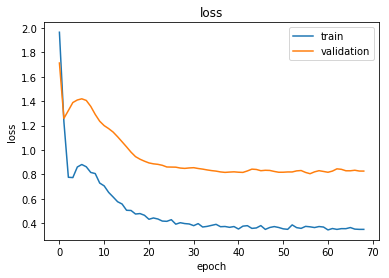

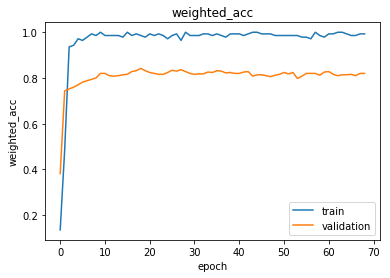

In [25]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [26]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set

In [27]:
test_gen = generator.flow(test_data.index, test_targets)

In [28]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.9825
	weighted_acc: 0.7955


### Making predictions with the model

Now let's get the predictions for all nodes:

Note that the `predict` or `predict_generator` function now operates differently to the `GraphSAGE` or `HinSAGE` models
in that if you give it a set of nodes, it will still return predictions for **all** nodes in the graph, and in a fixed order defined by the order of nodes in `X` and `A` (which is defined by the order of `G.nodes()`).

In [29]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [30]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few (note that generator orders nodes according to the order in G.nodes(), so the predictions are ordered like that as well. We thus need to index results as `G.nodes()`

In [31]:
results = pd.DataFrame(node_predictions, index=G.nodes()).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(20)

,Predicted,True
35,subject=Genetic_Algorithms,Genetic_Algorithms
40,subject=Genetic_Algorithms,Genetic_Algorithms
114,subject=Reinforcement_Learning,Reinforcement_Learning
117,subject=Reinforcement_Learning,Reinforcement_Learning
128,subject=Reinforcement_Learning,Reinforcement_Learning
130,subject=Reinforcement_Learning,Reinforcement_Learning
164,subject=Theory,Theory
288,subject=Reinforcement_Learning,Reinforcement_Learning
424,subject=Case_Based,Rule_Learning
434,subject=Case_Based,Reinforcement_Learning


## Node embeddings

Evaluate node embeddings as activations of the output layer and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

We are going to project the node embeddings to 2d using either TSNE or PCA transform, and visualise them, coloring nodes by their true subject label.

**Note:** The generator orders nodes according to the order in G.nodes(), so we need to re-index `node_data` so that the labels `y` correctly correspond to the rows in `X`.

In [32]:
X = all_predictions
y = np.argmax(target_encoding.transform(node_data.reindex(G.nodes())[["subject"]].to_dict('records')), axis=1)

In [33]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

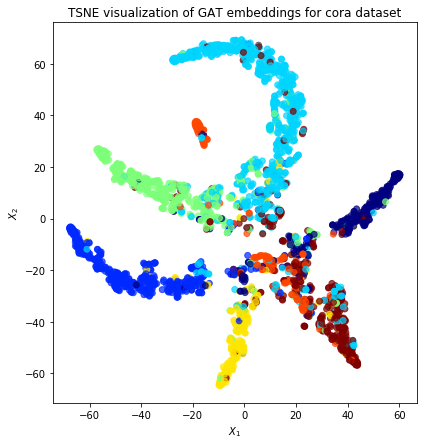

In [34]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GAT embeddings for cora dataset'.format(transform.__name__))
plt.show()